In [96]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

In [97]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [98]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [99]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [100]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [101]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [102]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [103]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

Checking for null values...
There are 211 null values - dropping!
Plotting precipitation data...


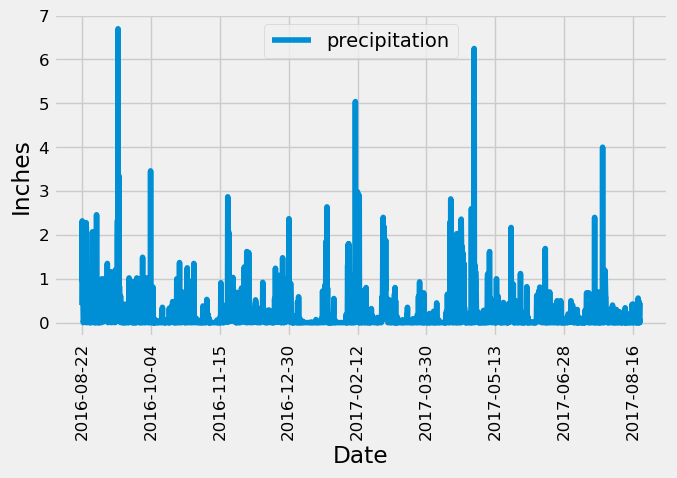

In [115]:
# Find the most recent date in the data set.
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_dt = (dt.datetime.strptime(last_date, "%Y-%m-%d")).date()
date_oneyearago = last_dt - dt.timedelta(days=366)
prcp_data = session.query(Measurement.date, Measurement.prcp).\
            filter((Measurement.date >= date_oneyearago)\
                    & (Measurement.date <= last_dt)).all()

prcp_df = pd.DataFrame(prcp_data).sort_values("date").set_index("date")


prcp_df.rename(columns={"prcp":"precipitation"}, inplace=True)

# Drop nulls
print("Checking for null values...")
print(f"There are {prcp_df['precipitation'].isnull().sum()} null values - dropping!")

prcp_df.dropna(axis=0, how="any", inplace=True)

print("Plotting precipitation data...")

prcp_df.plot(figsize=(7,5), fontsize=12, rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")

plt.tight_layout()
plt.savefig("Output/last12mon.png")
plt.show()

In [105]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [106]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).distinct().count()

9

In [107]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  order_by(func.count(Measurement.station).desc()).\
                  group_by(Measurement.station).\
                  all()

# --- display the active stations ---
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [108]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# --- identify most active station ---
most_active_station = active_stations[0][0]
print (f"The most active station is {most_active_station}.")
print("***************************************")

# --- calculate lowest temp recorded at the most active station USC00519281 ---
lowest_temp = session.query(func.min(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()
              
print(f"Lowest temperature: {lowest_temp} degrees Fahrenheit.")

# --- calculate highest temp recorded at the most active station USC00519281 ---
highest_temp = session.query(func.max(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()

print(f"Highest temperature: {highest_temp} degrees Fahrenheit.")

# --- calculate average temp recorded at the most active station USC00519281 ---
avg_temp = session.query(func.avg(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()

print(f"Average temperature: {round(avg_temp, 2)} degrees Fahrenheit.")

The most active station is USC00519281.
***************************************
Lowest temperature: 54.0 degrees Fahrenheit.
Highest temperature: 85.0 degrees Fahrenheit.
Average temperature: 71.66 degrees Fahrenheit.


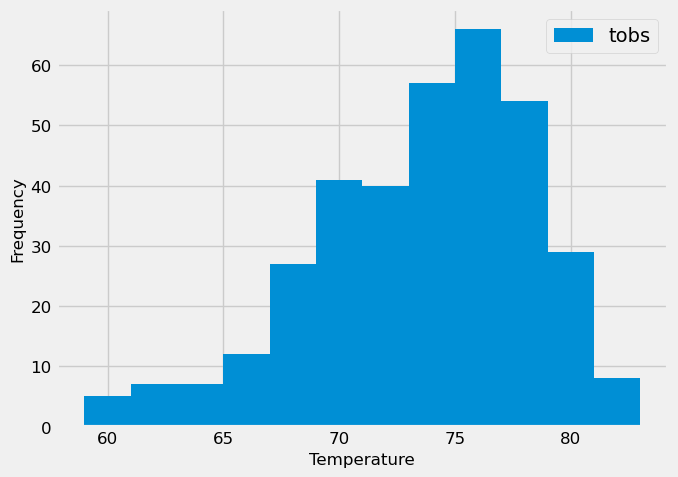

In [112]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = pd.DataFrame(session.query(Measurement.tobs).\
                                filter((Measurement.station == most_active_station)\
                                        & (Measurement.date >= date_oneyearago)\
                                        & (Measurement.date <= last_dt)).all())

most_active_tobs.plot(kind="hist", figsize=(7,5), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.savefig("Output/tobs.png")
plt.show()


# Close Session

In [110]:
# Close Session
session.close()